In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

In [11]:
import numpy as np

25 / 64  + 9/64

0.53125

In [2]:
import zipfile

In [3]:
with zipfile.ZipFile('/home/alex/jupyter/plates.zip', 'r') as zip_obj:
    zip_obj.extractall('/home/alex/jupyter/plates/')

In [4]:
os.listdir('/home/alex/jupyter/plates/')

['plates', '__MACOSX']

In [5]:
root_data = '/home/alex/jupyter/plates/plates'
os.listdir(root_data)

['test', '.DS_Store', 'train']

In [6]:
import shutil # для работы с файлами
from tqdm import tqdm # для визуализации progreesbar

In [10]:
# создаю две новые папки, то есть формирую выборку с валидацией
train_dir = 'train'

class_names = ['cleaned', 'dirty']
# буду каждую 6 фотографию из train отправлять в val


# Метод makedirs() является рекурсивной функцией создания каталога. 
# Подобно mkdir(), но создает все каталоги промежуточного уровня,
# необходимые для содержания конечного каталога.

for dir_name in [train_dir, ]:
    for class_name in class_names:
        os.makedirs(os.path.join(dir_name, class_name), exist_ok=True)
 # создали 2 паки train и val и в каждой папке еще  папки clean и dirty


# скопировали из папки plates грязные и чистые тарелки в 2 новые выборки
# train и val, для копирования использовали shutil.copy
for class_name in class_names:
    source_dir = os.path.join(root_data, 'train', class_name)
    print(source_dir)
    
    for i, file_name in enumerate(tqdm(os.listdir(source_dir))):
            dest_dir = os.path.join(train_dir, class_name)
        
            shutil.copy(os.path.join(source_dir, file_name), os.path.join(dest_dir, file_name))

/home/alex/jupyter/plates/plates/train/cleaned


100%|██████████████████████████████████████████| 21/21 [00:00<00:00, 418.11it/s]


/home/alex/jupyter/plates/plates/train/dirty


100%|████████████████████████████████████████| 21/21 [00:00<00:00, 10847.34it/s]


In [11]:
!ls train

cleaned  dirty


In [43]:
# теперь нам нужно создать некий итератор по этим директориям,
# чтобы они получали картинки, формировали из этих картинок тензоры и 
# батчи с изображениями и чтобы их  уже можно было передавать в НС

# pytorch предоставляет такую функциональность, для этого используется 
# ImageFolder из torchvisions.datasets.ImageFolder позволяет получать
# пары изображение-метка и итерировать по ним
# но ему нужно передть еще второй аргумент, чтобы он превратил изображения в тензоры



In [12]:
import torch
import torchvision
import time
import copy

from torchvision import transforms, models

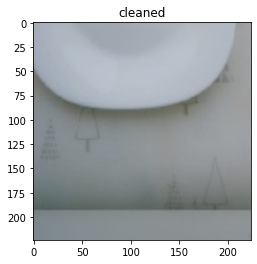

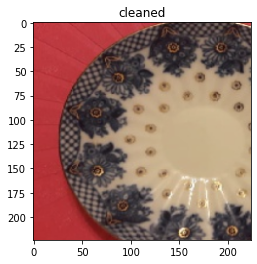

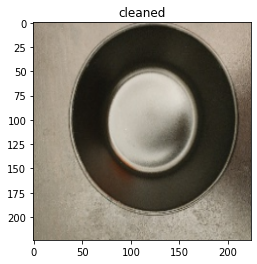

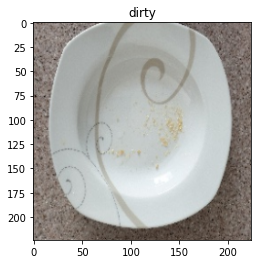

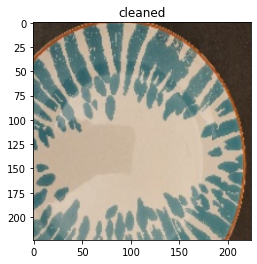

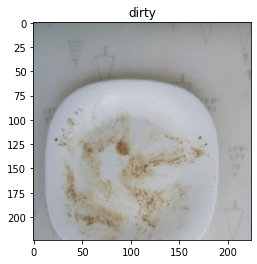

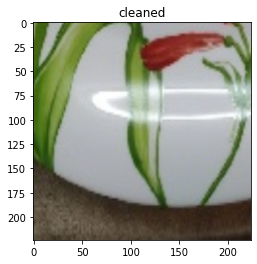

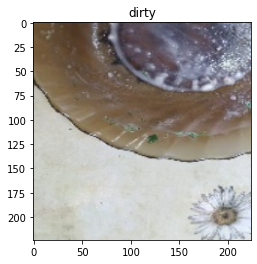

In [13]:
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    
])

val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_dataset = torchvision.datasets.ImageFolder(train_dir, train_transforms)

batch_size = 8
train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, num_workers=batch_size
)




# составим функцию, чтобы это не писать каждый раз

def show_input(input_tensor, title=''):
    image = input_tensor.permute(1, 2, 0).numpy()
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]
    image = std * image + mean
    plt.imshow(image.clip(0, 1))
    plt.title(title)
    plt.show()
    plt.pause(0.001)
    
X_batch, y_batch = next(iter(train_dataloader))


for x_item, y_item in zip(X_batch, y_batch):
    show_input(x_item, title=class_names[y_item])

In [14]:
len(train_dataloader), len(train_dataset)

(5, 40)

In [15]:
x, y = next(iter(train_dataloader)) # конструкция для получения первого батча

In [16]:
len(x), len(y)

(8, 8)

In [17]:
X_batch, y_batch = next(iter(train_dataloader))
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

X_batch[0].shape # то есть после того как применили метод ToTensor, то 
# каналы перешли в другую позицию!!, чтобы отрисовать изображение нужно их вернуть обратно



torch.Size([3, 224, 224])

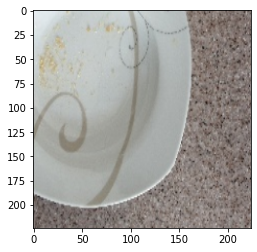

In [18]:
plt.imshow(X_batch[1].permute(1, 2, 0).numpy() * std + mean)

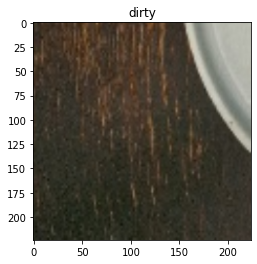

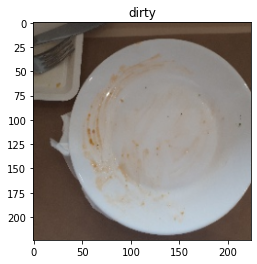

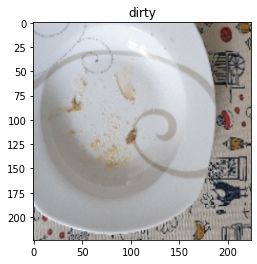

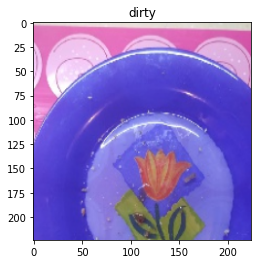

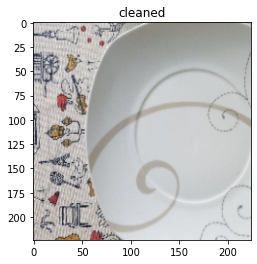

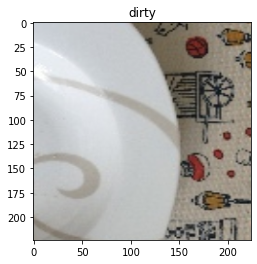

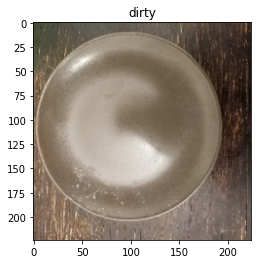

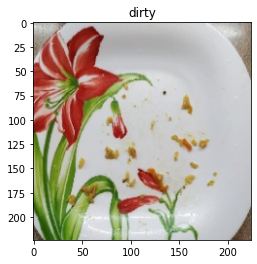

In [19]:
# составим функцию, чтобы это не писать каждый раз

def show_input(input_tensor, title=''):
    image = input_tensor.permute(1, 2, 0).numpy()
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]
    image = std * image + mean
    plt.imshow(image.clip(0, 1))
    plt.title(title)
    plt.show()
    plt.pause(0.001)
    
X_batch, y_batch = next(iter(train_dataloader))


for x_item, y_item in zip(X_batch, y_batch):
    show_input(x_item, title=class_names[y_item])
    

In [20]:
# функция каждую эпоху прохдит по батчам; если это фаза обучения, то она делает bakward()
# и у optimizer делает шаги ГС. А если фаза валидации, то просто считаем качество валидации

def train_model(model, loss, optimizer, scheduler, num_epochs):
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}:'.format(epoch, num_epochs - 1), flush=True)
        
        for phase in ['train',]:
            
            if phase == 'train':
                dataloader = train_dataloader # батчи из тренировчного датасета
                # делаем шаг в планировщике, который скажет, что прошла эпоха (каждые 7 шагов) 
                scheduler.step() 
                model.train()

            
            running_loss = 0.
            running_acc = 0.
            
            
            for inputs, labels in tqdm(dataloader): # итерируемся по тенировочному сету, он отдает батч с тензорами
                # и батч с метками
                optimizer.zero_grad() # обнуляем градиент
                
                
                # если фаза train, то активируем незамороженные градиенты для обучения
                # также эта обертка позволяет не сохранять всю цепочку обучения, а это огромная информация, была бы утечка памяти

                with torch.set_grad_enabled(phase == 'train'):
                    preds = model(inputs) # вычисляем предсказания
                    loss_value = loss(preds, labels) # считаем ошибку
                    preds_class = preds.argmax(dim=1) # предсказанный класс
                    
                    if phase == 'train':
                        loss_value.backward()
                        optimizer.step()
                        
                # подсчет статистик
                running_loss += loss_value.item()
                running_acc += (preds_class == labels.data).float().mean()

            epoch_loss = running_loss / len(dataloader) # делим на длину батчей
            epoch_acc = running_acc / len(dataloader)
            
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc), flush=True)
            
    return model

In [35]:
# создадим модель на основе resnet18

model = models.resnet152(pretrained=True) # используем предобученные веса. 18 говорит, что здесь 18 слоев

# замораживаем веса, чтобы сетка заново не обучала слои, используем в итоге только последний слой

for param in model.parameters(): 
    param.requires_grad = False # вычсиление градиента не трубется, вся сетка заморожена
    
model.fc = torch.nn.Linear(model.fc.in_features, 2) # создаем слой, 512 нейронов на вход и на выход 2, так как 2 класса


loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1.0e-2)

# планировщик сдвига шага градиентного спуска
# с теченение обучения иногда есть смысл уменьшать шаг обучения
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=6, gamma=0.01)

In [36]:
train_model(model, loss, optimizer, scheduler, num_epochs=30);


Epoch 0/29:


100%|█████████████████████████████████████████████| 5/5 [00:04<00:00,  1.18it/s]

train Loss: 3.4683 Acc: 0.5000
Epoch 1/29:



100%|█████████████████████████████████████████████| 5/5 [00:04<00:00,  1.22it/s]

train Loss: 2.3176 Acc: 0.5750
Epoch 2/29:



100%|█████████████████████████████████████████████| 5/5 [00:04<00:00,  1.22it/s]

train Loss: 1.1890 Acc: 0.6250
Epoch 3/29:



100%|█████████████████████████████████████████████| 5/5 [00:04<00:00,  1.22it/s]

train Loss: 0.8733 Acc: 0.6750
Epoch 4/29:



100%|█████████████████████████████████████████████| 5/5 [00:04<00:00,  1.21it/s]

train Loss: 0.6423 Acc: 0.8000
Epoch 5/29:



100%|█████████████████████████████████████████████| 5/5 [00:04<00:00,  1.23it/s]

train Loss: 0.1648 Acc: 0.9250
Epoch 6/29:



100%|█████████████████████████████████████████████| 5/5 [00:04<00:00,  1.21it/s]

train Loss: 0.3300 Acc: 0.9250
Epoch 7/29:



100%|█████████████████████████████████████████████| 5/5 [00:04<00:00,  1.21it/s]

train Loss: 0.2516 Acc: 0.9250
Epoch 8/29:



100%|█████████████████████████████████████████████| 5/5 [00:04<00:00,  1.22it/s]

train Loss: 0.1777 Acc: 0.9500
Epoch 9/29:



100%|█████████████████████████████████████████████| 5/5 [00:04<00:00,  1.22it/s]

train Loss: 0.1059 Acc: 0.9750
Epoch 10/29:



100%|█████████████████████████████████████████████| 5/5 [00:04<00:00,  1.22it/s]

train Loss: 0.4589 Acc: 0.9000
Epoch 11/29:



100%|█████████████████████████████████████████████| 5/5 [00:04<00:00,  1.21it/s]

train Loss: 0.1802 Acc: 0.9250
Epoch 12/29:



100%|█████████████████████████████████████████████| 5/5 [00:04<00:00,  1.22it/s]

train Loss: 0.2620 Acc: 0.9000
Epoch 13/29:



100%|█████████████████████████████████████████████| 5/5 [00:04<00:00,  1.21it/s]

train Loss: 0.2435 Acc: 0.9250
Epoch 14/29:



100%|█████████████████████████████████████████████| 5/5 [00:04<00:00,  1.21it/s]

train Loss: 0.2173 Acc: 0.9500
Epoch 15/29:



100%|█████████████████████████████████████████████| 5/5 [00:04<00:00,  1.22it/s]

train Loss: 0.5734 Acc: 0.8000
Epoch 16/29:



100%|█████████████████████████████████████████████| 5/5 [00:04<00:00,  1.14it/s]

train Loss: 0.1073 Acc: 0.9500
Epoch 17/29:



100%|█████████████████████████████████████████████| 5/5 [00:04<00:00,  1.21it/s]

train Loss: 0.3166 Acc: 0.9000
Epoch 18/29:



100%|█████████████████████████████████████████████| 5/5 [00:04<00:00,  1.22it/s]

train Loss: 0.1232 Acc: 0.9500
Epoch 19/29:



100%|█████████████████████████████████████████████| 5/5 [00:04<00:00,  1.11it/s]

train Loss: 0.1419 Acc: 0.9250
Epoch 20/29:



100%|█████████████████████████████████████████████| 5/5 [00:04<00:00,  1.22it/s]

train Loss: 0.1714 Acc: 0.9000
Epoch 21/29:



100%|█████████████████████████████████████████████| 5/5 [00:04<00:00,  1.22it/s]

train Loss: 0.1241 Acc: 0.9500
Epoch 22/29:



100%|█████████████████████████████████████████████| 5/5 [00:04<00:00,  1.23it/s]

train Loss: 0.1331 Acc: 0.9500
Epoch 23/29:



100%|█████████████████████████████████████████████| 5/5 [00:04<00:00,  1.22it/s]

train Loss: 0.3211 Acc: 0.8750
Epoch 24/29:



100%|█████████████████████████████████████████████| 5/5 [00:04<00:00,  1.22it/s]

train Loss: 0.3891 Acc: 0.8500
Epoch 25/29:



100%|█████████████████████████████████████████████| 5/5 [00:04<00:00,  1.21it/s]

train Loss: 0.1988 Acc: 0.9000
Epoch 26/29:



100%|█████████████████████████████████████████████| 5/5 [00:04<00:00,  1.22it/s]

train Loss: 0.1896 Acc: 0.9500
Epoch 27/29:



100%|█████████████████████████████████████████████| 5/5 [00:04<00:00,  1.22it/s]

train Loss: 0.1434 Acc: 0.9000
Epoch 28/29:



100%|█████████████████████████████████████████████| 5/5 [00:04<00:00,  1.22it/s]

train Loss: 0.1471 Acc: 0.9500
Epoch 29/29:



100%|█████████████████████████████████████████████| 5/5 [00:04<00:00,  1.22it/s]

train Loss: 0.2806 Acc: 0.9000


In [37]:
# теперь попытаемся обработать test датасет
# к сожалению ImageFolder не может напрямую обработать папку с изображениями

test_dir = 'test'
shutil.copytree(os.path.join(root_data, 'test'), os.path.join(test_dir, 'unknown'))

FileExistsError: [Errno 17] File exists: 'test/unknown'

In [38]:
class ImageFolderWithPaths(torchvision.datasets.ImageFolder):
    def __getitem__(self, index):
        original_tuple = super(ImageFolderWithPaths, self).__getitem__(index)
        path = self.imgs[index][0]
        tuple_with_path = (original_tuple + (path,))
        return tuple_with_path
    
test_dataset = ImageFolderWithPaths('/home/alex/jupyter/test', val_transforms)

test_dataloader = torch.utils.data.DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

In [39]:
test_dataset

Dataset ImageFolderWithPaths
    Number of datapoints: 744
    Root location: /home/alex/jupyter/test
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

In [40]:
model.eval()


test_predictions = []
test_img_paths = []
for inputs, labels, paths in tqdm(test_dataloader):
    
    with torch.set_grad_enabled(False):
        preds = model(inputs)
    test_predictions.append(
        torch.nn.functional.softmax(preds, dim=1)[:,1].data.cpu().numpy())
    test_img_paths.extend(paths)
    
test_predictions = np.concatenate(test_predictions)

100%|███████████████████████████████████████████| 93/93 [01:07<00:00,  1.37it/s]


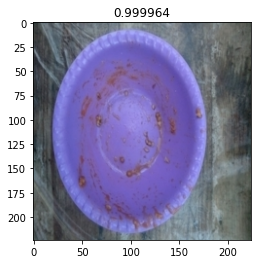

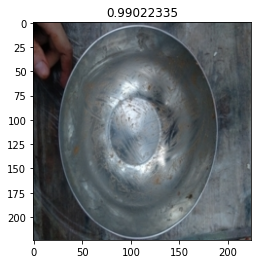

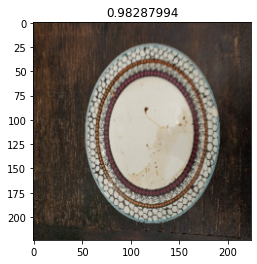

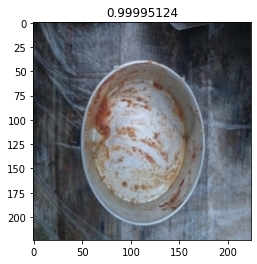

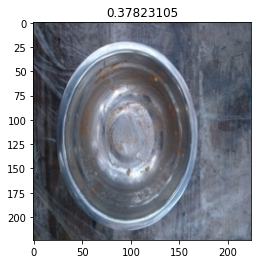

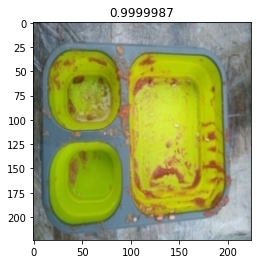

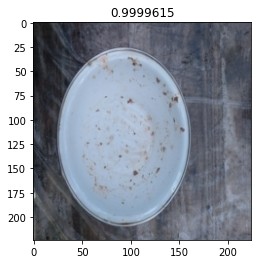

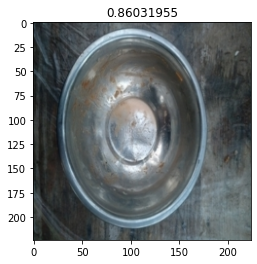

In [42]:
inputs, labels, paths = next(iter(test_dataloader))

for img, pred in zip(inputs, test_predictions):
    show_input(img, title=pred)

In [43]:
submission_df = pd.DataFrame.from_dict({'id': test_img_paths, 'label': test_predictions})

In [44]:
submission_df['label'] = submission_df['label'].map(lambda pred: 'dirty' if pred > 0.5 else 'cleaned')
submission_df['id'] = submission_df['id'].str.replace('/home/alex/jupyter/test/unknown/', '')
submission_df['id'] = submission_df['id'].str.replace('.jpg', '')
submission_df.set_index('id', inplace=True)
submission_df.head(n=6)

/tmp/ipykernel_35093/1242412898.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  submission_df['id'] = submission_df['id'].str.replace('.jpg', '')


,label
id,
0000,dirty
0001,dirty
0002,dirty
0003,dirty
0004,cleaned
0005,dirty


In [45]:
submission_df.to_csv('submission.csv')
